In [2]:
# Check the GPU
!nvidia-smi

Thu Feb  8 04:55:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:0D:00.0 Off |                  Off |
| 30%   40C    P8              35W / 300W |      2MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 51.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 92.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 82.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━

In [4]:
from huggingface_hub import login
login()

In [5]:
!pip install git+https://github.com/huggingface/diffusers.git 

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-ecitdzpg
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-ecitdzpg
  Resolved https://github.com/huggingface/diffusers.git to commit 1835510524a058da1d3b3c5f951bbaaae5b21421
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.26.0.dev0-py3-none-any.whl size=1945625 sha256=7ca9df04ad814cb460aca6b21c78206268f7c72a6582198fdf4a59113a943d6f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3s83hl1h/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-02-08 04:57:09--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74958 (73K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  73.20K  --.-KB/s    in 0.004s  

2024-02-08 04:57:09 (18.5 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [74958/74958]



In [7]:
from PIL import Image

def image_grid(imgs, 
               rows, 
               cols, 
               resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

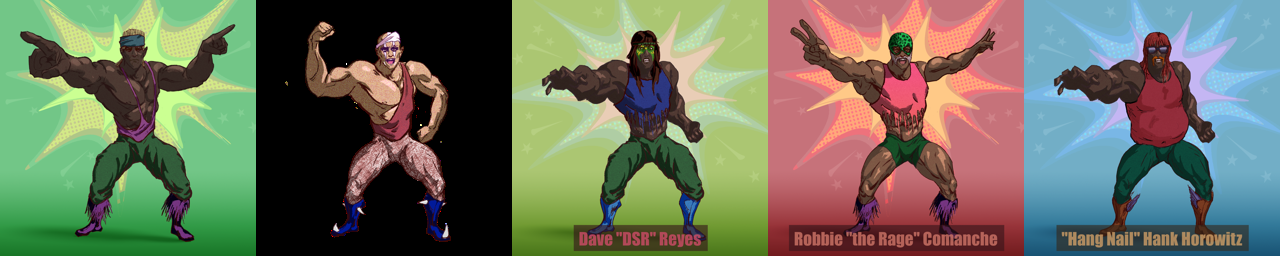

In [8]:
import glob

img_paths = "./train_image/*.png"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [9]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",
                                                          torch_dtype=torch.float16).to(device)

def caption_images(input_image):
    
    inputs = blip_processor(images=input_image, 
                            return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values
    generated_ids = blip_model.generate(pixel_values=pixel_values, 
                                        max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, 
                                                    skip_special_tokens=True)[0]
    return generated_caption

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
import glob
from PIL import Image

local_dir = "./train_image/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.png")]

In [13]:
import json

caption_prefix = "a photo of TOK cartoon hero, " 
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

In [14]:
import gc

del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [17]:
!pip install datasets 

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 66.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 79.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [33]:
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="train_image" \
  --output_dir="train_image_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of TOK cartoon character" \
  --resolution=1024 \
  --train_text_encoder \
  --train_batch_size=4 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=2000 \
  --checkpointing_steps=717 \
  --seed="0"

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:393: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
02/08/2024 07:08:46 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'thresholding', 'clip_sample_range', 'variance_type', 're

In [34]:
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", 
                                         torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.load_lora_weights("/workspace/train_image_LoRA")
refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", 
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16"
)
refiner.to("cuda")
generator = torch.Generator("cuda").manual_seed(0)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
from tqdm import tqdm  
   
for _ in tqdm(range(100), desc="Processing iterations"):
    
    prompt = "A picture of a TOK cartoon character"
    latent_image = pipe(prompt=prompt, 
                        output_type="latent", 
                        generator=generator).images[0]
    
    refined_image = refiner(prompt=prompt, 
                            image=latent_image[None, :], 
                            generator=generator).images[0]
    
    output_filename = f"/workspace/output_dir/refined_sks_iteration_{_ + 1}.png"
    refined_image.save(output_filename)

Processing iterations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   1%|          | 1/100 [00:15<25:38, 15.54s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   2%|▏         | 2/100 [00:31<25:31, 15.63s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   3%|▎         | 3/100 [00:47<25:23, 15.70s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   4%|▍         | 4/100 [01:02<25:13, 15.76s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   5%|▌         | 5/100 [01:18<25:03, 15.82s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   6%|▌         | 6/100 [01:34<24:50, 15.86s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   7%|▋         | 7/100 [01:50<24:37, 15.88s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   8%|▊         | 8/100 [02:06<24:23, 15.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:   9%|▉         | 9/100 [02:22<24:09, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  10%|█         | 10/100 [02:38<23:55, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  11%|█         | 11/100 [02:54<23:39, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  12%|█▏        | 12/100 [03:10<23:24, 15.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  13%|█▎        | 13/100 [03:26<23:07, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  14%|█▍        | 14/100 [03:42<22:51, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  15%|█▌        | 15/100 [03:58<22:35, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  16%|█▌        | 16/100 [04:14<22:18, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  17%|█▋        | 17/100 [04:30<22:01, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  18%|█▊        | 18/100 [04:46<21:45, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  19%|█▉        | 19/100 [05:01<21:29, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  20%|██        | 20/100 [05:17<21:13, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  21%|██        | 21/100 [05:33<20:57, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  22%|██▏       | 22/100 [05:49<20:41, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  23%|██▎       | 23/100 [06:05<20:25, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  24%|██▍       | 24/100 [06:21<20:09, 15.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  25%|██▌       | 25/100 [06:37<19:53, 15.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  26%|██▌       | 26/100 [06:53<19:37, 15.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  27%|██▋       | 27/100 [07:09<19:21, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  28%|██▊       | 28/100 [07:25<19:05, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  29%|██▉       | 29/100 [07:41<18:50, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  30%|███       | 30/100 [07:57<18:34, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  31%|███       | 31/100 [08:12<18:17, 15.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  32%|███▏      | 32/100 [08:28<18:01, 15.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  33%|███▎      | 33/100 [08:44<17:46, 15.91s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  34%|███▍      | 34/100 [09:00<17:30, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  35%|███▌      | 35/100 [09:16<17:14, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  36%|███▌      | 36/100 [09:32<16:58, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  37%|███▋      | 37/100 [09:48<16:43, 15.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  38%|███▊      | 38/100 [10:04<16:27, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  39%|███▉      | 39/100 [10:20<16:11, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  40%|████      | 40/100 [10:36<15:55, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  41%|████      | 41/100 [10:52<15:40, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  42%|████▏     | 42/100 [11:08<15:24, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  43%|████▎     | 43/100 [11:24<15:08, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  44%|████▍     | 44/100 [11:40<14:52, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  45%|████▌     | 45/100 [11:55<14:36, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  46%|████▌     | 46/100 [12:11<14:21, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  47%|████▋     | 47/100 [12:27<14:05, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  48%|████▊     | 48/100 [12:43<13:49, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  49%|████▉     | 49/100 [12:59<13:33, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  50%|█████     | 50/100 [13:15<13:17, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  51%|█████     | 51/100 [13:31<13:01, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  52%|█████▏    | 52/100 [13:47<12:45, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  53%|█████▎    | 53/100 [14:03<12:29, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  54%|█████▍    | 54/100 [14:19<12:13, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  55%|█████▌    | 55/100 [14:35<11:57, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  56%|█████▌    | 56/100 [14:51<11:41, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  57%|█████▋    | 57/100 [15:07<11:25, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  58%|█████▊    | 58/100 [15:23<11:09, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  59%|█████▉    | 59/100 [15:39<10:54, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  60%|██████    | 60/100 [15:55<10:38, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  61%|██████    | 61/100 [16:11<10:22, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  62%|██████▏   | 62/100 [16:27<10:05, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  63%|██████▎   | 63/100 [16:43<09:50, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  64%|██████▍   | 64/100 [16:59<09:33, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  65%|██████▌   | 65/100 [17:14<09:17, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  66%|██████▌   | 66/100 [17:30<09:01, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  67%|██████▋   | 67/100 [17:46<08:45, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  68%|██████▊   | 68/100 [18:02<08:29, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  69%|██████▉   | 69/100 [18:18<08:13, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  70%|███████   | 70/100 [18:34<07:58, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  71%|███████   | 71/100 [18:50<07:41, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  72%|███████▏  | 72/100 [19:06<07:25, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  73%|███████▎  | 73/100 [19:22<07:10, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  74%|███████▍  | 74/100 [19:38<06:54, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  75%|███████▌  | 75/100 [19:54<06:38, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  76%|███████▌  | 76/100 [20:10<06:22, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  77%|███████▋  | 77/100 [20:26<06:06, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  78%|███████▊  | 78/100 [20:42<05:50, 15.93s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  79%|███████▉  | 79/100 [20:57<05:34, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  80%|████████  | 80/100 [21:13<05:18, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  81%|████████  | 81/100 [21:29<05:02, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  82%|████████▏ | 82/100 [21:45<04:47, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  83%|████████▎ | 83/100 [22:01<04:31, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  84%|████████▍ | 84/100 [22:17<04:15, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  85%|████████▌ | 85/100 [22:33<03:59, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  86%|████████▌ | 86/100 [22:49<03:43, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  87%|████████▋ | 87/100 [23:05<03:27, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  88%|████████▊ | 88/100 [23:21<03:11, 15.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  89%|████████▉ | 89/100 [23:37<02:55, 15.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  90%|█████████ | 90/100 [23:53<02:39, 15.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  91%|█████████ | 91/100 [24:09<02:23, 15.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  92%|█████████▏| 92/100 [24:25<02:07, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  93%|█████████▎| 93/100 [24:41<01:51, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  94%|█████████▍| 94/100 [24:57<01:35, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  95%|█████████▌| 95/100 [25:13<01:19, 15.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  96%|█████████▌| 96/100 [25:29<01:03, 15.96s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  97%|█████████▋| 97/100 [25:45<00:47, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  98%|█████████▊| 98/100 [26:01<00:31, 15.95s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations:  99%|█████████▉| 99/100 [26:17<00:15, 15.94s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing iterations: 100%|██████████| 100/100 [26:32<00:00, 15.93s/it]
